# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [8]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [11]:
# add any additional libaries you need here

import nltk
nltk.download('brown')


[nltk_data] Downloading package brown to
[nltk_data]     /Users/mammajamma/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [9]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [12]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [13]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [14]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

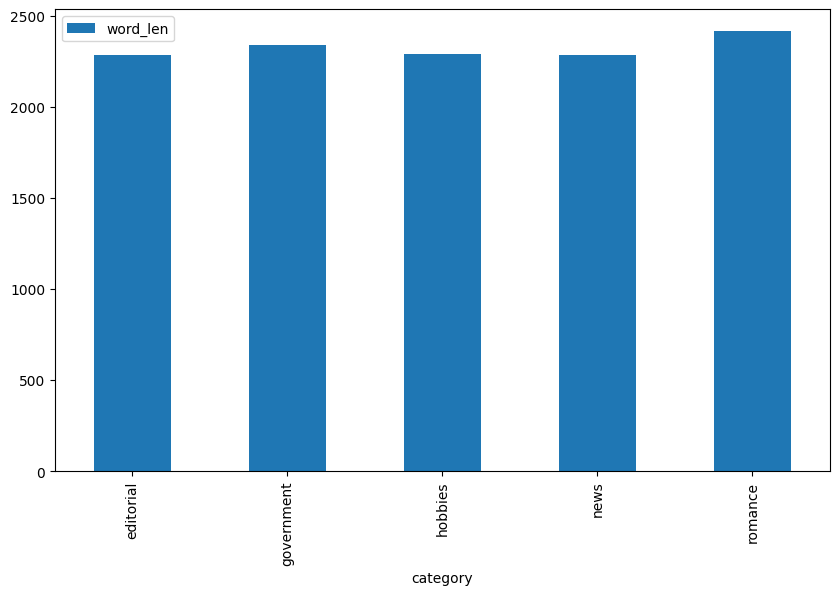

In [15]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [16]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/mammajamma/Projects/Superstore-Analytics/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [17]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The two data frames, count_text_vectors and tfidf_text_vectors, both store numerical versions of the Brown corpus text so they can be used for topic modeling. The count_text_vectors data shows how many times each word is in every document, giving a count of word frequency. The tfidf_text_vectors data goes a step further by weighting each word based on how common or rare it is across all documents, which helps to display more important words. Each row represents a document, each column represents a unique word, and together they create a document-term matrices that models like NMF, LSA, and LDA use to identify topics.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [18]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/Users/mammajamma/Projects/Superstore-Analytics/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/mammajamma/Projects/Superstore-Analytics/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/mammajamma/Projects/Superstore-Analytics/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


In [19]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [ ]:
# Your code here
# assign each document to its strongest NMF topic
df['nmf_topic'] = np.argmax(W_text_matrix, axis=1)

# Create a cross-tabulation to see how NMF topics align with Brown categories
topic_category_table = pd.crosstab(df['nmf_topic'], df['category'])

topic_category_table


category,editorial,government,hobbies,news,romance
nmf_topic,,,,,
0,20,4,0,8,0
1,4,0,8,0,29
2,2,26,26,11,0
3,0,0,1,17,0
4,1,0,1,8,0


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The NMF model grouped the documents into five main topics that roughly align with the Brown categories, though some overlap occurs.  For example, Topic 1 shows a mix of government and romance, implying some overlap in general language use across those texts.  Generally though, the NMF model captures the broad thematic similarities but not perfectly because its not separated by labels but rather by shared word similarities. 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [21]:
# Your code here
from sklearn.decomposition import TruncatedSVD

# Fit a five-topic LSA model using the same TF-IDF matrix
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
lsa_W = lsa_text_model.fit_transform(tfidf_text_vectors)

# Assign each document to its strongest LSA topic
df['lsa_topic'] = np.argmax(lsa_W, axis=1)

# Compare LSA topics to Brown categories
lsa_topic_table = pd.crosstab(df['lsa_topic'], df['category'])
lsa_topic_table


/Users/mammajamma/Projects/Superstore-Analytics/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/mammajamma/Projects/Superstore-Analytics/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/mammajamma/Projects/Superstore-Analytics/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


category,editorial,government,hobbies,news,romance
lsa_topic,,,,,
0,27,30,36,34,21
1,0,0,0,0,8
3,0,0,0,3,0
4,0,0,0,7,0


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model picked up on the main themes in the Brown corpus, but its results weren’t as clean or separated as the NMF model. It blended several of the categories—like news, government, and editorial—because they share a lot of the same vocabulary and tone. While it still captured the overall meaning and structure of the text, the categories overlapped more, making it harder to tell them apart compared to what I saw with NMF.

In [22]:
# call display_topics on your model
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())



Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: Looking at the display output, the top words for each topic show which terms carry the most weight in shaping those broader themes. Some topics are clearly more conversational, using words like “said,” “mr,” and “mrs,” while others lean toward political or formal language with words like “kennedy” and “khrushchev.” Overall, LSA highlights word patterns and shared context across documents, but it doesn’t split topics as sharply—it’s more about general relationships between ideas than distinct clusters.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [27]:
# Fit your LDA model here
from sklearn.decomposition import LatentDirichletAllocation

# Fit a five-topic LDA model using the count vectors
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_W = lda_text_model.fit_transform(count_text_vectors)




In [28]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The topics from the LDA model make sense and look more distinct than those from the previous methods. Each topic groups together words that seem to describe different styles of writing — for example, one looks like casual or narrative language with words such as “said,” “mrs,” and “little,” while another includes more formal or structured terms like “state,” “development,” and “program.” This shows that LDA does a good job of separating the documents by theme and language type.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: When I compared the LDA topics to the original Brown categories, there was a clear overlap with how the texts were labeled. Topics with government or news-related vocabulary mostly aligned with those same Brown categories, while narrative or conversational topics lined up more with romance or editorial. Overall, the LDA model captured the main themes pretty accurately and separated the topics more cleanly than LSA, while still being a little less sharp than NMF in some areas.

In [29]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [30]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The scatterplot shows that the five topics are pretty distinct from each other, with minimal overlap, so the model separated themes well. The bar chart highlights the most common and meaningful words in each topic (like state, mrs, and said) giving a good sense of what each topic represents. Overall, it confirms the LDA model captured clear, interpretable themes across the corpus.
